In [1]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:2"])
from tensorflow import keras
import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
import os
import fnmatch
import pandas as pd
import bezier

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

from PIL import Image, ImageDraw
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, UpSampling2D, ZeroPadding2D, Flatten, Conv1D, Conv2D, Conv3D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from keras.layers.merge import add, concatenate

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [2]:
plt.figure(figsize=(9, 9))
image_width = image_height = 400
gridcell = 10

image_root = './images/multi_lines/train/'
image_labels = ['line']

total_files = fnmatch.filter(os.listdir(image_root), '*.png')
#print(total_files)

df=pd.read_csv('./images/multi_lines/train.csv', sep=',',header=0)

def image_read(fn):
    link = os.path.join(image_root, fn)
    image = Image.open(link).convert('RGB')
    im = np.asarray(image)
    #print(im.shape)
    return im
    
def generate_bezier(x, y):
    nr = np.asarray(x, y)
    curve = bezier.Curve(nr, degree=1)
    
    return curve

def gen_plots():
    for i in range(9):
        rand_idx = randint(0, len(total_files))
        image, class_id, x, y = getInfo(rand_idx)
        ax = plt.subplot(3, 3, i+1)
        
        l1 = ax.imshow(image, extent=[0, image_height, 0, image_width])
        l1.set_label("")
        
        # Create bezier curve or plot a line
        '''
        curve = generate_bezier(x, y)
        g_truth = curve.plot(num_pts=256, color="r", ax=ax)
        g_truth.lines[-1].set_label('prediction var 1')
        g_truth.lines[-1].set_linestyle('dotted')
        g_truth.lines[-1].set_marker('+')
        g_truth.lines[-1].set_markersize(2)
        '''
        
        ax.plot(x, y, 'r+', linestyle='dotted', label='prediction')
        
        lines, labels = ax.get_legend_handles_labels()
        plt.legend( lines, labels, loc = 'best', bbox_to_anchor = (0,-0.1,1,1),
                    bbox_transform = plt.gcf().transFigure )
        
        plt.xlabel(image_labels[0])
        plt.xticks([])
        plt.yticks([])

#gen_plots()


def getInfo(fn):
    #print(fn)
    image = image_read(fn+".png")
    
    rows = np.where(df.filename==fn)
    
    class_id = df["class"][rows[0][0]]
    coords = []
    
    for i in rows[0]:
        c_id = []
        c_coord = []
        
        c_coord.append(df.xmin[i])
        c_coord.append(df.xmax[i])
        c_coord.append(df.ymin[i])
        c_coord.append(df.ymax[i])
        
        coords.append(c_coord)
        c_id = []
    
    return image, class_id, coords

<Figure size 648x648 with 0 Axes>

# PLOT LINE

In [3]:

def tester():
    rand_idx = randint(0, len(total_files))
    image, class_id, x, y = getInfo(rand_idx)
    return image

def plot_line(image, pred_coords, norm=False):
    figo = Figure(figsize=(2, 2))

    canvas = FigureCanvasAgg(figo)

    # plot
    ax_r = figo.add_subplot()
    if norm:
        image *= 255.
        image = image.astype(np.uint8)
    ax_r.imshow(image, extent=[0,image_height,0,image_width])
    
    for i in pred_coords:
        xmin, xmax, ymin, ymax = i
        ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    
    '''
    if len(pred_coords) == 2:
        x, y = pred_coords
        #print(x, y)
        xmin = x[0]
        xmax = x[1]
        ymin = y[0]
        ymax = y[1]
        ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    '''
    ax_r.set_axis_off()

    canvas.draw()

    buf = canvas.buffer_rgba()
    # ... convert to a NumPy array ...
    X = np.asarray(buf)
    # ... and pass it to PIL.
    im = Image.fromarray(X)

    return im

def randlGen():
    rElem = np.random.choice(total_files)
    rElem = rElem[0:-4]
    return rElem

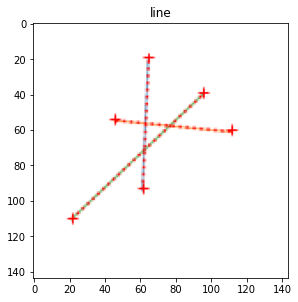

In [20]:
#rand_idx = randint(0, len(total_files))

image, class_id, pred_coords = getInfo(randlGen())

image = plot_line(image, pred_coords,norm=False)
plt.imshow(np.flipud(image))
plt.title("line")
plt.tight_layout(pad=0)
plt.show()

# Ground truth pixels with testing (DISBANDED!)

In [5]:


def gtDistance1(index, test):
    
    threshold = 0.01
    image, class_id, p1, p2 = getInfo(index)

    gTruth = np.zeros((h,w,1))
    
    p1 = np.asarray([x / image_height for x in p1])
    p2 = np.asarray([x / image_width for x in p2])
    
    #print(p1)
    
    for i,j in enumerate(image):
        for k,l in enumerate(image):
            x1 = i/h 
            x2 = k/w
            p3 = np.asarray([x1,x2])
            
            dis = np.abs(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)
            #print(dis)
            if(test != True):
                if (dis <= threshold):
                    gTruth[i][k] = 1
                else:
                    gTruth[i][k] = 0
            else:
                if (dis <= threshold):
                    gTruth[i][k] = 0
                else:
                    gTruth[i][k] = 255
    #print(gTruth)
    return gTruth


def gtNaive(index):
    image, class_id, x, y = getInfo(index)
    # Naive non-generalized method
    
    gTruth = np.zeros((h,w,1))
    #x[0][0] = [2]
    
    for i,j in enumerate(image):
        for k,l in enumerate(image):
            if (np.all(image[i][k] == 255)):
                gTruth[i][k] = 0
            else:
                gTruth[i][k] = 255
    return [image,gTruth]

#gtNaive(1)

#test_sbs(311, gtDistance2)

'''
x, y = gtNaive(103)

plt.subplot(1, 2, 1)
plt.imshow(x)
plt.subplot(1, 2, 2)
plt.imshow(y)
'''
'''
def linear(coord):
    
    n_a = []
    
    for i in coord:
        OldValue = i
        OldMax = 143
        OldMin = 0
        NewMax = 17
        NewMin = 0
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        x = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        n_a.append(x)
    
    return np.asarray(n_a)
'''
def gtDistance2(index, test):
    
    threshold = 1
    image_orig, class_id, p1, p2 = getInfo(index)
    image = image_orig.reshape((1,image_height,image_width,3))
    
    gTruth = np.zeros((gridcell,gridcell,1))
    
    y = tf.image.extract_patches(images=image,
                           sizes=[1, 8, 8, 1],
                           strides=[1, 8, 8, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME')
    
    p1 = linear(p1)
    p2 = linear(p2)
    #print(p1, p2)
          
    for x in y[0]:
        for i,j in enumerate(x):
            for k,l in enumerate(x):
                #print(i,k)
                
                p3 = np.asarray([i,k])
                #print(p1, p2, p3)

                dis = np.abs(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)
                #print(dis)
                
                if(test != True):
                    if (dis <= threshold):
                        gTruth[i][k] = 1
                    else:
                        gTruth[i][k] = 0
                else:
                    if (dis <= threshold):
                        gTruth[i][k] = 0
                    else:
                        gTruth[i][k] = 255
    #print(gTruth.shape)
    #plt.imshow(gTruth)
    return gTruth
    
    
#gtDistance2(178, False)



'''
def test_sbs(index, method):
    image, class_id, x, y = getInfo(index)
    pimg = method(index, False)
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(pimg)
    
    plt.subplot(121)
    plt.plot(image)
    plt.subplot(121)
    plt.plot(pimg)
'''  
#test_sbs(133, gtDistance2)
    

'\ndef test_sbs(index, method):\n    image, class_id, x, y = getInfo(index)\n    pimg = method(index, False)\n    \n    plt.subplot(1, 2, 1)\n    plt.imshow(image)\n    plt.subplot(1, 2, 2)\n    plt.imshow(pimg)\n    \n    plt.subplot(121)\n    plt.plot(image)\n    plt.subplot(121)\n    plt.plot(pimg)\n'

# Pixel gTruth and Line gTruth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


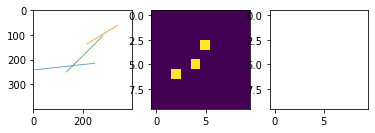

In [52]:

def linear(coord):
    n_a = []
    
    for i in coord:
        OldValue = i
        OldMax = image_width-1
        OldMin = 0
        NewMax = gridcell-1
        NewMin = 0
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        x = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        n_a.append(x)
    
    return np.asarray(n_a)

def midPoint(p12):
    x1, x2, y1, y2 = p12
    
    x = (x1 + x2)/2
    y = (y1 + y2)/2
    
    return x,y

def gtruther(index):

    image, class_id, coords = getInfo(index)
    
    #truther shapes
    pxTruth = np.zeros((gridcell,gridcell,1))
    liTruth = np.zeros((gridcell,gridcell,4))
    mps = []
    
    if (class_id == 1):
        for i in coords:
            x1, x2, y1, y2 = i
            
            #p12 = i
            #mapping
            #print("old coords: ", i)
            p12 = linear(i)
            #print("new coords: ", p12)

            #find mp
            mp = midPoint(p12)
            mp = np.around(mp)
            #print(mp)
            #mp coords
            y, x = mp.astype(int)

            #line coords
            x1, x2, y1, y2 = p12

            #allot line gt coords of mp coords to liTruth shape
            liTruth[y][x] = i
            pxTruth[y][x] = [class_id]
            mps.append([y,x])
            

    return image, liTruth, pxTruth, mps
    
#gtruther("li_200")

def test_sbs(index):
    image, class_id, coords = getInfo(index)
    pimg, liTruth, pxTruth, mps = gtruther(index)
    
    plt.subplot(1, 3, 1)
    #plt.tight_layout(pad=0)
    plt.imshow(np.flipud(image))
    plt.subplot(1, 3, 2)
    plt.imshow(pxTruth)
    plt.subplot(1, 3, 3)
    plt.imshow(liTruth)
    
test_sbs("li_403")

In [67]:
def weight_calc(bline_batch, mps):
    sample_weight = np.zeros((gridcell,gridcell,4))
    
    for i in mps:
        y, x = i
        sample_weight[y][x] = 1.5
    
    for i in sample_weight:
        print(i)

# DATA GEN

In [68]:
# check line 13 later - random???"

batch_size = len(total_files)
def data_generator(batch_size=batch_size):
    while True:
        x_batch = np.zeros((batch_size, image_height, image_width, 3))
        y_batch = np.zeros((batch_size, gridcell, gridcell, 1))
        bline_batch = np.zeros((batch_size, gridcell, gridcell, 4))
        #print(bline_batch)

        for i,j in enumerate(total_files[0:batch_size]):
            #j = j[0:-4]

            image, liTruth, pxTruth, mps = gtruther(randlGen())

            x_batch[i] = image / 255.
            y_batch[i] = pxTruth
            bline_batch[i] = liTruth
            sample_weight = weight_calc(bline_batch[i], mps)
            #print(({'image': x_batch}, {'class_out': y_batch, 'line_out': bline_batch}))

        yield ({'image': x_batch}, {'class_out': y_batch, 'line_out': bline_batch}, {'line_out': sample_weight})

In [69]:
def extractor(class_id, pred_coords):

    #for label
    count = 0
    pos = []
    coords = []

    #gT label
    for i,j in enumerate(class_id):
        for k,l in enumerate(class_id):
            if(class_id[i][k] == 1):
                pos.append([i,k])
                count = count + 1

    for i,j in enumerate(pred_coords):
        for k,l in enumerate(pred_coords):
            if (all(i != 0 for i in pred_coords[i][k])):
                coords.append(pred_coords[i][k])

    #print(count, coords)
    return count, coords


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [1.5 1.5 1.5 1.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [1.5 1.5 1.5 1.

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [1.5 1.5 1.5 1.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

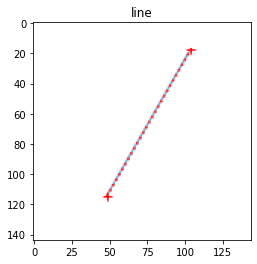

In [70]:
def testerxo():
    index = 95
    example, label, sample_weight = next(data_generator(100))
    image = example['image'][index]
    class_id = label['class_out'][index]
    pred_coords = label['line_out'][index]

    count, coords = extractor(class_id, pred_coords)

    image = plot_line(image, coords, norm=True)

    plt.imshow(image)
    plt.title('line')
    plt.show()

    '''
    x = [pred_coords[0], pred_coords[1]]
    y = [pred_coords[2], pred_coords[3]]

    image = plot_line(image, pred_coords=[x, y], norm=True)

    plt.imshow(image)
    plt.title('line')
    plt.show()
    '''
testerxo()

# MODEL

In [10]:
'''
def model2():
    
    backbone             = keras.applications.MobileNet(include_top=False, pooling='avg')
    classification_layer = keras.layers.Dense(1, activation='softmax', name='class_out')
    regression_layer     = keras.layers.Dense(4, name='box_out')

    x = x0   = keras.Input(shape=(None,None,3), name='image')
    x        = backbone(x)
    x1        = classification_layer(x)
    x2        = regression_layer(x)
    model    = keras.Model(inputs=x0, outputs=[x1, x2])
    
    return model
'''

"\ndef model2():\n    \n    backbone             = keras.applications.MobileNet(include_top=False, pooling='avg')\n    classification_layer = keras.layers.Dense(1, activation='softmax', name='class_out')\n    regression_layer     = keras.layers.Dense(4, name='box_out')\n\n    x = x0   = keras.Input(shape=(None,None,3), name='image')\n    x        = backbone(x)\n    x1        = classification_layer(x)\n    x2        = regression_layer(x)\n    model    = keras.Model(inputs=x0, outputs=[x1, x2])\n    \n    return model\n"

In [11]:
#model = model2()
#model.summary()

In [12]:

def modelTester():
    input_ = Input(shape=(image_height, image_width, 3), name='image')

    x = input_

    for i in range(0, 5):
      n_filters = 2**(4 + i)
      x = Conv2D(n_filters, 3, activation='relu')(x)
      x = BatchNormalization()(x)
      x = MaxPool2D(2)(x)
    
    x1 = Conv2D(1, (1,1), name="class_out")(x)
    x2 = Conv2D(4, (1,1), name="line_out")(x)
    
    model = tf.keras.models.Model(input_, [x1,x2])
    model.summary()
    return model
    
model = modelTester()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 398, 398, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 398, 398, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 199, 199, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
def model1():
    h = w = 600
    
    backbone             = keras.applications.MobileNet(input_shape=(h,w,3), include_top=False)
    
    x = x0   = keras.Input(shape=(h,w,3), name='image')
    x        = backbone(x)
    
    x1 = Conv2D(1, (1,1), name="class_out")(x)
    x2 = Conv2D(4, (1,1), name="line_out")(x)
    #x = Conv2D(2048, (7, 7), strides = (1, 1))(x)
    model    = keras.Model(inputs=x0, outputs=[x1,x2])
    
    return model

#model = model1()
#model.summary()

In [14]:

#_metrics = ['tf.keras.metrics.RootMeanSquaredError()', '']
model.compile(
    loss={
        'class_out': 'binary_crossentropy',
        'line_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'line_out': [tf.keras.metrics.MeanAbsoluteError()]
    }
)

In [15]:
def test_model(model, test_datagen):
    
    example, label = next(test_datagen)
    
    image = example['image']
    class_id = label['class_out']
    
    #gtruth lines
    coords = label['line_out']
    gtcount, gtcoords = extractor(class_id[0], coords[0])
    
    #predicted lines
    pred_class, pred_line = model.predict(image)
    pred_count, pred_coords = extractor(pred_class[0], pred_line[0])

    #class_id
    gt = 0 if gtcount == 0 else 1
    pred_class_name = 0 if pred_count == 0 else 1
    
    image = plot_line(image[0], pred_coords)

    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(np.flipud(image))
    
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    '''
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['line_out'][0]   

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    xc = [pred_coords[0], pred_coords[1]]
    yc = [pred_coords[2], pred_coords[3]]

    #print(xc, yc)

    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = "line"
    pred_class_name = "line"

    box = [[box[0], box[1]], [box[2], box[3]]]

    image = plot_line(image, pred_coords=[xc, yc], norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    #plt.show()
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    '''

In [16]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()
  

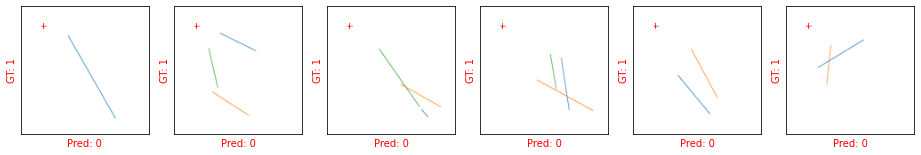

In [17]:
test(model)

In [18]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

# Model Training

Epoch 1/50
500/500 [==============================] - 675s 1s/step - loss: 557.5513 - class_out_loss: 0.4621 - line_out_loss: 557.0891 - class_out_accuracy: 0.9651 - line_out_mean_absolute_error: 4.0466


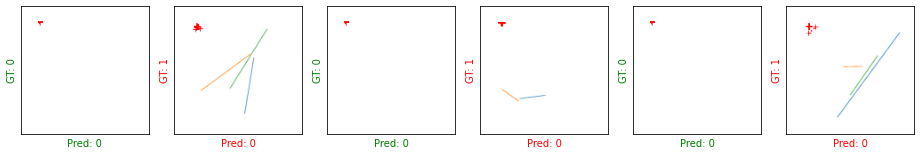

Epoch 2/50
500/500 [==============================] - 597s 1s/step - loss: 329.8624 - class_out_loss: 0.2282 - line_out_loss: 329.6340 - class_out_accuracy: 0.9848 - line_out_mean_absolute_error: 3.0658


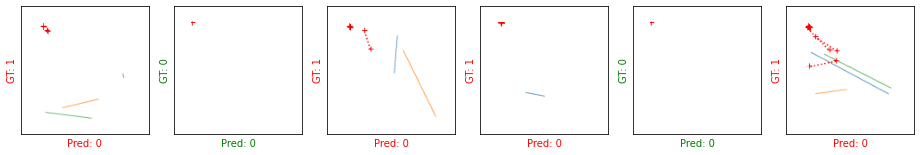

Epoch 3/50
500/500 [==============================] - 595s 1s/step - loss: 318.9492 - class_out_loss: 0.2141 - line_out_loss: 318.7349 - class_out_accuracy: 0.9859 - line_out_mean_absolute_error: 2.8560


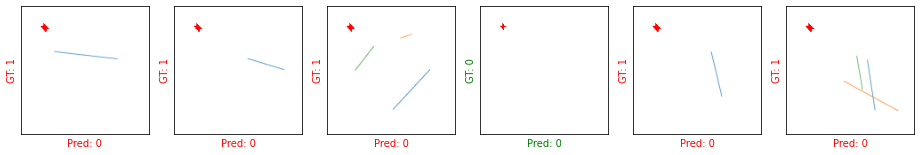

Epoch 4/50
500/500 [==============================] - 586s 1s/step - loss: 309.9438 - class_out_loss: 0.1934 - line_out_loss: 309.7503 - class_out_accuracy: 0.9874 - line_out_mean_absolute_error: 2.7677


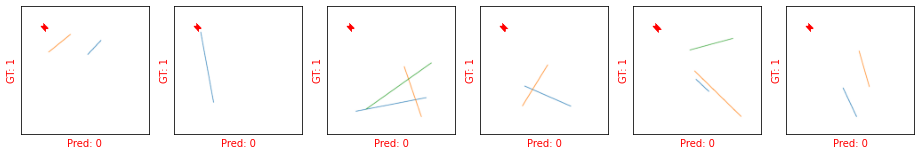

Epoch 5/50
165/500 [========>.....................] - ETA: 6:45 - loss: 297.7188 - class_out_loss: 0.1632 - line_out_loss: 297.5555 - class_out_accuracy: 0.9893 - line_out_mean_absolute_error: 2.6708

Process Keras_worker_ForkPoolWorker-4:
Process Keras_worker_ForkPoolWorker-5:
Process Keras_worker_ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-1:
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessin

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-10:
Process Keras_worker_ForkPoolWorker-8:
Process Keras_worker_ForkPoolWorker-9:
Process Keras_worker_ForkPoolWorker-7:
Process Keras_worker_ForkPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/mag/Abrar/miniconda3/envs/tf-gpu/lib/python3.8/multiprocessing/process.py", line 108, in run
    se

In [19]:
keras.backend.clear_session()

def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)


_ = model.fit(
    data_generator(batch_size=100),
    use_multiprocessing=True,
    workers=5,
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               #tf.keras.callbacks.EarlyStopping(monitor='line_out_mean_absolute_error', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)